МФТИ: Data Mining in Action (осень, 2016)

* Дмитрий Персиянов, <dmitry.persiyanov@gmail.com>, https://vk.com/persiyanov
* Арсений Ашуха, <ars.ashuha@gmail.com>, https://vk.com/ars.ashuha

<h1 align='center'>Домашнее задание №1: линейные модели, бустинг</h1>

**Дополнительный материал для выполнения дз**:

*Линейные модели*:
- Лекция 2, DMIA: https://goo.gl/luURTu
- Логистическая регрессия, UFLDL Tutorial: http://ufldl.stanford.edu/tutorial/supervised/LogisticRegression/
- Линейная регрессия, UFLDL Tutorial: http://ufldl.stanford.edu/tutorial/supervised/LinearRegression/

*Бустинг*:
- Hastie, The Elements of Statistical Learning, https://goo.gl/k3wfEU, 10 Boosting and Additive Trees 337
- Соколов, Семинары по композиционным методам, https://goo.gl/sn8RyJ, http://goo.gl/ajNTQy



**Оформление дз**: 
- Присылайте выполненное задание на почту ``datamininginaction@gmail.com``
- Укажите тему письма в следующем формате ``DMIA2016_fall <направление> <фамилия>_<имя> HW1``, к примеру -- ``DMIA2016_fall trends ivanov_ilya HW1``

**Вопросы**:
- Задавайте вопросы в issues на гитхабе: https://github.com/vkantor/MIPT_Data_Mining_In_Action_2016/issues
- Либо в группу или нам в личные сообщения: https://vk.com/data_mining_in_action
------------

<h1 align='center'>Overview</h1>

На последней лекции вы узнали про классические модели машинного обучения, которые каждый Data Scientist должен знать и понимать, как они работают.

В этом домашнем задании мы предлагаем вам реализовать две модели: одну линейную -- логистическую регрессию, и модель бустинга над деревьями, а также сравнить их качество на одном датасете.

-----------

<h1 align='center'>Part 1: Logistic Regression</h1>

In [1]:
import pandas as pd
import numpy as np
import tqdm # interactive progress bar

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## 1. Знакомство с данными
Данные представляют собой выборку отзывов о еде с сайта Амазон. Для них проставлены метки -- положительный или отрицательный отзыв.

In [2]:
train_df = pd.read_csv('./data/train.csv')

In [3]:
print train_df.shape

(110163, 3)


In [4]:
train_df.Prediction.value_counts(normalize=True)

0    0.50074
1    0.49926
Name: Prediction, dtype: float64

Видим, что классы сбалансированы. Можем оценивать качество модели по метрике ```accuracy```.

In [5]:
train_df.head()

,ID,Reviews_Summary,Prediction
0,239071,Michigan Cherries,1
1,466160,Great Product,1
2,397133,Ovaltine,1
3,297146,~,1
4,292685,Love it!,1


In [6]:
train_df.tail()

,ID,Reviews_Summary,Prediction
110158,486256,Terrible!,0
110159,199050,"Cheap Coffee, No Banana Flavor",0
110160,278179,Not as described,0
110161,87500,Tastes like a squirt of toothpaste mixed into ...,0
110162,121963,Disappointed,0


----------
## 2. Извлечение признаков
Для решения задачи классификации необходимо преобразовать каждый отзыв (документ) в вектор. Размерность данного вектора будет равна количеству слов используемых в корпусе (все документы). Каждая координата соответствует слову, значение в координает равно количеству раз, слово используется в документе. 

Для решения данной задачи вам необходимо написать код, который преобразовывает матрицу документов в численную матрицу.

Дополнительная информация для решения задачи:

- Подробнее про векторное представление документов: http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
- Используйте данный трансформер: http://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage
- Подробнее про разреженные матрицы: http://docs.scipy.org/doc/scipy-0.14.0/reference/sparse.html
- Hashing trick: https://en.wikipedia.org/wiki/Feature_hashing

Помните, что все эти трансформеры возвращают ```sparse```-матрицы. Учитывая это и то, что линейные модели достаточно хорошо масштабируются на большое количество фич, можно смело ставить ```n_features``` 1000+.

In [7]:
review_summaries = list(train_df['Reviews_Summary'].values)
review_summaries = [l.lower() for l in review_summaries]

In [8]:
review_summaries[:5]

['michigan cherries', 'great product', 'ovaltine', '~', 'love it!']

Преобразуйте ```review_summaries``` с помощью ```TfidfVectorizer```.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
vectorizer = CountVectorizer()
tfidfed = vectorizer.fit_transform(review_summaries)

In [11]:
vectorizer

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [12]:
print tfidfed[0]
print review_summaries[2641]

  (0, 2641)	1
  (0, 9000)	1
tea greatness


In [13]:
f = vectorizer.get_feature_names()
print len(f), f[9000], f[2641]

16230 michigan cherries


In [18]:
from sklearn.cross_validation import train_test_split
X = tfidfed
print type(X)
y = train_df.Prediction.values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

<class 'scipy.sparse.csr.csr_matrix'>


## 3. Логистическая регрессия

Логистическая регрессия -- линейный классификатор, который очень часто используется на практике, например, в кредитном скоринге. Преимущества этой модели -- скорость обучения и предсказания (даже при сотнях тысяч фичей) а также интепретируемость: важные признаки имеют бОльшие по модулю веса. 

При этом отрицательные веса говорят, что фича важна для определения класса 0, а положительные -- для определения класса 1. Это можно понять, если вспомнить, что разделяющая поверхность линейных моделей, это $w^Tx = 0$, а значение алгоритма есть $a(x) = sign(w^Tx)$.

Будем предсказывать сентимент, подготовим данные и сделаем валидационную выборку. Вы ведь теперь знаете, что нужно оценивать качество модели не по обучающей выборке, а по валидационной. Иначе вы переобучитесь, когда будете тюнить гиперпараметры модели.

-----
** Реализуйте код в модуле ```dmia.classifiers.logistic_regression```.**

-----

In [23]:
from dmia.gradient_check import *
from dmia.classifiers import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Gradient check

В этой ячейке вы можете проверить, правильно ли у вас все работает, прежде чем обучать модель на всех данных.

In [24]:
X_train_sample = X_train[:10000]
y_train_sample = y_train[:10000]
clf = LogisticRegression()
print X_train_sample.shape
clf.w = np.random.randn(X_train_sample.shape[1]+1) * 2
clf.train(X_train_sample, y_train_sample)
print clf.w
y_prob = clf.predict_proba(X_train_sample, append_bias = True)

(10000, 16230)
-1.81172912044
-1.93929516206
-2.04923002263
-1.97963978215
-2.10841048539
-1.61918861874
-2.15004357387
-1.80688084633
-1.93264717152
-2.04114836652
-1.32725842771
-2.20273948806
-2.03872596839
-1.95295972398
-1.80208444137
-1.97223053987
-1.95586955622
-1.9789034512
-2.14048382299
-1.65676345675
-1.93644378307
-2.02737313755
-2.35389174893
-2.0293350736
-2.03336136153
-2.07959893478
-1.8649080104
-1.77155531387
-1.95341752647
-2.03470284775
-2.11222594442
-2.21612884369
-2.15561784399
-1.84106743444
-1.73963605352
-1.92124319332
-2.00580107582
-2.12708397477
-1.97099382394
-1.94184613206
-1.97969600386
-2.1416324306
-2.08157129229
-1.90205268913
-2.56350776335
-1.7768007969
-1.63277431946
-1.63117723416
-2.15721022541
-2.21485662965
-1.84753294047
-2.23280028365
-1.82325669043
-2.20331165049
-2.05660064307
-1.96766802654
-2.02943582603
-1.7819431474
-1.77973423813
-2.07641059533
-1.75542498627
-1.75819901934
-1.62994457509
-2.09423136268
-2.07894514287
-2.01214403289
-

In [39]:
print y_prob[:10]
print y_prob[-10:]
y_pred = clf.predict(X_train_sample)
print y_pred[:10]
print y_pred[-10:]
X_b = clf.append_biases(X_train_sample)
loss, grad = clf.loss(X_b.toarray(), y_train_sample, 1e-5)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
f = lambda w: clf.loss(X_b.toarray(), y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, clf.w, grad, 10)
print f

[[ 0.83697379  0.16302621]
 [ 0.66802825  0.33197175]
 [ 0.16980945  0.83019055]
 [ 0.9980445   0.0019555 ]
 [ 0.96941493  0.03058507]
 [ 0.47157217  0.52842783]
 [ 0.16369303  0.83630697]
 [ 0.29292741  0.70707259]
 [ 0.08739356  0.91260644]
 [ 0.87977052  0.12022948]]
[[ 0.00148001  0.99851999]
 [ 0.99515475  0.00484525]
 [ 0.73438226  0.26561774]
 [ 0.03888314  0.96111686]
 [ 0.73305689  0.26694311]
 [ 0.94285335  0.05714665]
 [ 0.37316235  0.62683765]
 [ 0.10524636  0.89475364]
 [ 0.45285135  0.54714865]
 [ 0.93789589  0.06210411]]
(10000, 16231)
(10000, 16231) (10000, 16231)
(10000, 2)
[0 0 1 0 0 1 1 1 1 0]
[1 0 0 1 0 0 1 1 1 0]
-2.47101123591
-1.81637253024
-1.81637253091
numerical: 0.000034 analytic: 0.000047, relative error: 1.649638e-01
-1.81637253057
-1.81637253057
numerical: 0.000000 analytic: 0.000037, relative error: 1.000000e+00
-1.81637253057
-1.81637253057
numerical: 0.000000 analytic: 0.000053, relative error: 1.000000e+00
-1.81637253057
-1.81637253057
numerical: 0.000

In [40]:
k = len([i for i in range(10000) if y_pred[i] == y_train_sample[i]])
print k

5359


In [32]:
print sum(y_pred)

4770


In [59]:
from scipy import sparse
a = np.ones(200)
a = a.reshape((200, 1))
b = np.ones((200, 16999))
c = a * b

Обучите свою модель на ```X_train, y_train```.

Для начала можете взять параметры по умолчанию, и найти оптимальные используя валидацию.

In [34]:
clf = LogisticRegression()

In [35]:
clf.train(X_train, y_train)

-0.693514721032
-0.692936134143
-0.693815014217
-0.694301349567
-0.694011885955
-0.692803463109
-0.693303683052
-0.69346188
-0.6934120936
-0.692807613585
-0.693137682279
-0.693348806152
-0.693186886336
-0.693225590294
-0.693410488479
-0.693313001108
-0.692899076371
-0.692992066241
-0.693513877504
-0.692851906339
-0.694077095946
-0.692940263268
-0.693098001497
-0.693146532994
-0.693015272992
-0.692491142571
-0.692592014136
-0.692901074614
-0.693003654543
-0.693582837948
-0.694716969757
-0.693417970613
-0.693619391946
-0.692799493289
-0.693885271004
-0.69292318525
-0.693599182432
-0.693626946798
-0.69340392104
-0.693363281273
-0.692968954695
-0.693279655024
-0.693409978257
-0.693230310737
-0.693117074456
-0.693107024534
-0.693315669778
-0.693268579451
-0.693214195379
-0.692896909864
-0.693019136749
-0.693022459159
-0.693128381014
-0.69289509746
-0.693386236758
-0.69254548337
-0.693210344163
-0.693577555996
-0.692620382429
-0.69395300005
-0.693731131136
-0.693621555559
-0.692574596721
-0.

<dmia.classifiers.logistic_regression.LogisticRegression instance at 0x7f49bce9ccb0>

Посмотрим на качество на валидации.

In [36]:
print "Train f1-score = %.3f" % accuracy_score(y_train, clf.predict(X_train))
print "Test f1-score = %.3f" % accuracy_score(y_test, clf.predict(X_test))

(77114, 16231)
(77114, 16231) (77114, 16231)
(77114, 2)
Train f1-score = 0.516
(33049, 16231)
(33049, 16231) (33049, 16231)
(33049, 2)
Test f1-score = 0.522


Нарисуем кривые обучения.

In [40]:
clf = LogisticRegression()
train_scores = []
test_scores = []
num_iters = 10

for i in tqdm.trange(num_iters):
    # Сделайте один шаг градиентного спуска с помощью num_iters=1
    clf.train(X_train, y_train, num_iters = 1)
    train_scores.append(accuracy_score(y_train, clf.predict(X_train)))
    test_scores.append(accuracy_score(y_test, clf.predict(X_test)))

  0%|          | 0/10 [00:00<?, ?it/s]

-0.692972232539
(77114, 16231)
(77114, 16231) (77114, 16231)


MemoryError: 

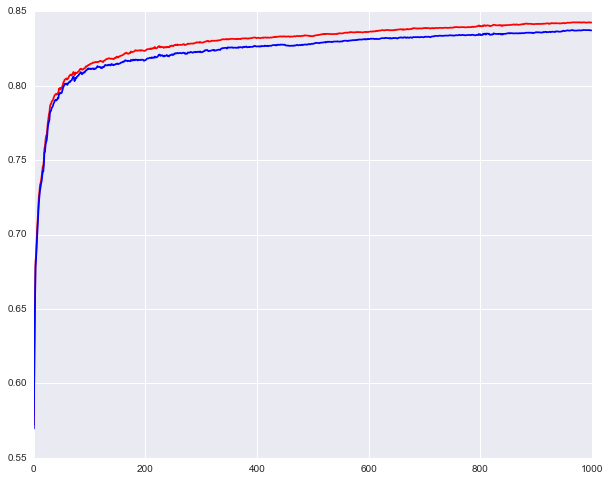

In [103]:
plt.figure(figsize=(10,8))
plt.plot(train_scores, 'r', test_scores, 'b')

## 4. Задание

* Обучите вашу модель **на всех данных**, преобразовав их через ```TfidfVectorizer``` с ```max_features=3000```.

* Параметры модели ```learning_rate=1.0, num_iters=1000, batch_size=256, reg=1e-3``` и выведите первые 5 самых важных фичей для класса 1 и 5 фичей для класса 0. Убедитесь, что они коррелируют с вашей интуицией о хороших/плохих отзывах. 


* Топ позитивных фичей перечислите через запятую под пунктом 1 в письме с кодом.

* Топ негативных фичей перечислите через запятую под пунктом 1 в письме с кодом.


**Hint:** зная индекс фичи, само слово вы можете получить, используя метод ```vectorizer.get_feature_names()```.

**Hint:** ```np.argsort```.

In [ ]:
# Обучите модель
clf = LogisticRegression(learning_rate = 1.0, num_iters = 1000, batch_size = 256, reg = 1e-3)

In [ ]:
# Получите индексы фичей
pos_features = ...
neg_features = ...

In [ ]:
# Выведите слова
...

## 5. Сравнение с sklearn.linear_model.LogisticRegression

Обучите такую же модель, но из пакета ```sklearn.linear_model``` и убедитесь, что ваша имплементация ничем не хуже (ну или почти не хуже).

In [42]:
from sklearn import linear_model

In [43]:
clf = linear_model.LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [44]:
print "Train accuracy = %.3f" % accuracy_score(y_train, clf.predict(X_train))
print "Test accuracy = %.3f" % accuracy_score(y_test, clf.predict(X_test))

Train accuracy = 0.924
Test accuracy = 0.896


## 6. Что дальше?
* Нам повезло, что классы в нашем датасете сбалансированы. Какие проблемы возникнут у логистической регрессии, если, скажем, будет 90% нулевого класса и 10% первого. Как нужно изменить код, чтобы исправить эту проблему? Постарайтесь придумать не менее 2х способов.
* Почему мы не делаем регуляризацию для bias term в весах? Может, все таки, в каких-то случаях ее стоит делать?

Ответы на вопросы напишите здесь.

-----
<h1 align='center'>Part 2: Boosting</h1>

### Градиентный спуск

Самый простой метод минимизации функции, для оптимизации в каждый момент времени двигаемся по антиградиенту функции с каким-то шагом. 


$$w_{n+1} = w_n - s \cdot \frac{\partial f}{\partial w}$$

### Градиентный бустинг

Теперь давайте представим, что на каждом шаге мы оптимизируем не параметры алгоритма $w$, а ответы нашего алгоритма $\hat{y}$.

**Обучение**: На каждом шаге, давайте предсказывать градиент на каждом объекте и "двигать" ответ в сторону улучшения (антиградиента).

**Как в итоге обучать**:
- Первый алгоритм отвечает константу 
- Добавляем базовые алгоритмы $b_i$, $i = 1, .., N$:
    - Вычисляем градиент функции потерь ПО ОТВЕТАМ модели $g_{i-1} = \frac{\partial L(\hat{y},~~y)}{\partial \hat{y}} = \frac{\partial L(\sum_{j=0}^{i-1} a_j b_j(x),~~y)}{\partial \sum_{j=0}^{i-1} a_j b_j(x)}$ на каждом объекте  
    - Обучаем $b_i$ предсказывать текущий $g_{i-1}$
    - Подбираем $a_i$ -- одномерной минимизацией 
    - Дополняем композицию $\sum_{j=0}^{i-1} a_j b_j (x) + a_i b_i(x)$

## 1. Simple test

-----
** Реализуйте код в модуле ```dmia.classifiers.binary_boosting```.**

-----

In [26]:
from dmia.classifiers import BinaryBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from dmia.utils import plot_surface

X, y = make_classification(n_samples=500, n_features=2,
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)
y = 2*(y-0.5)

In [27]:
clf = BinaryBoostingClassifier(n_estimators=100).fit(X, y)
plot_surface(X, y, clf)

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

## 2. Outliers

Посмотрим на выбросы.

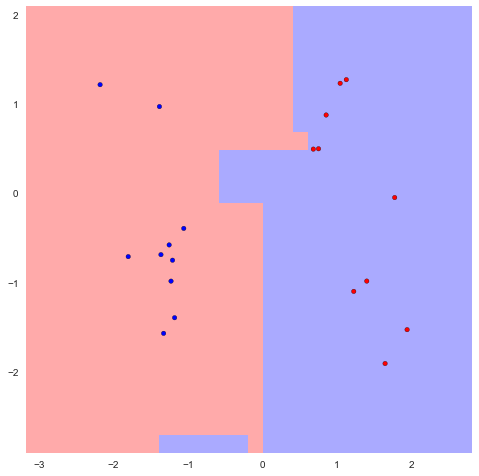

In [107]:
outliers_indices = clf.out_
plot_surface(X[outliers_indices], y[outliers_indices], clf)

## 3. Sentiment

Вы обучали логистическую регрессию на 1000+ фичах и это было быстро.

Как вы думаете, разумно ли обучать бустинг над деревьями на 1000 фичах? А на 10000? 100000? Обоснуйте ответ в каждом случае. Если не разумно, то что можно предпринять?

Ответ напишите ниже.

In [25]:
clf = BinaryBoostingClassifier(n_estimators=100, max_depth=3).fit(X_train, y_train)

print "Train accuracy = %.3f" % accuracy_score(y_train, clf.predict(X_train))
print "Test accuracy = %.3f" % accuracy_score(y_test, clf.predict(X_test))

NameError: name 'BinaryBoostingClassifier' is not defined

## 4. Посмотрим на ```feature_importances_```

* Обучите бустинг **на всех данных**, обработав ```review_summaries``` с помощью ```TfidfVectorizer``` с ```max_features=1000```.

* Параметры модели возьмите ```lr=0.1, n_estimators=100, max_depth=3```.

* Найдите топ-10 самых важных фичей с точки зрения алгоритма.

* Перечислите эти 10 слов через запятую под пунктом 3 в своем письме с кодом.

In [43]:
vectorizer = TfidfVectorizer(max_features=1000)
tfidfed = vectorizer.fit_transform(review_summaries)

clf = BinaryBoostingClassifier(n_estimators=100, max_depth=3)
clf.fit(tfidfed, train_df.Prediction.values)

BinaryBoostingClassifier(lr=0.1, max_depth=None, n_estimators=100)

In [34]:
most_imp_features = ...

In [ ]:
# Напечатайте слова
...

## 5. Сравнение с sklearn.ensemble.GradientBoostingClassifier

Обучите градиентный бустинг из ```sklearn``` и сравните его качество на ```X_test``` с вашим (Оно не должно отличаться на много процентов! Вы образали деревья?)

In [46]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
clf = ...

In [ ]:
print "Train accuracy = %.3f" % accuracy_score(y_train, clf.predict(X_train))
print "Test accuracy = %.3f" % accuracy_score(y_test, clf.predict(X_test))